# Восстановление золота из руды

Мне нужно подготовить прототип модели машинного обучения для «Цифры», компании,которая разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды, что поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В процессе работы я подготовлю данные, проведу их исследовательский анализ, построю и обучу модель.

В ходе работы буду обращаться к библиотекам *pandas*, *matplotlib* и *sklearn.* 

**Описание данных**

Rougher feed — исходное сырье

Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

  Xanthate **— ксантогенат (промотер, или активатор флотации);
  Sulphate — сульфат (на данном производстве сульфид натрия);
  Depressant — депрессант (силикат натрия).
  
Rougher process (англ. «грубый процесс») — флотация

Rougher tails — отвальные хвосты

Float banks — флотационная установка

Cleaner process — очистка

Rougher Au — черновой концентрат золота

Final Au — финальный концентрат золота

Параметры этапов

air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи


Наименование признаков

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

rougher — флотация

primary_cleaner — первичная очистка

secondary_cleaner — вторичная очистка

final — финальные характеристики

Возможные значения для блока [тип_параметра]:

input — параметры сырья

output — параметры продукта

state — параметры, характеризующие текущее состояние этапа

calculation — расчётные характеристики




В ходе работы мне нужно смоделировать процесс восстановления золота из золотосодержащей руды, спрогнозировать сразу две величины:

эффективность обогащения чернового концентрата rougher.output.recovery;

эффективность обогащения финального концентрата final.output.recovery.


## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from numpy.random import RandomState
from sklearn.tree import DecisionTreeRegressor
pd.set_option('display.max_rows', None) #снимает ограничение на отображение количества строк
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


In [2]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')


 Информация об обучающей выборке 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                   

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


(14149, 87)

 Явных дубликатов 0

 Тепловая карта корелляции:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470


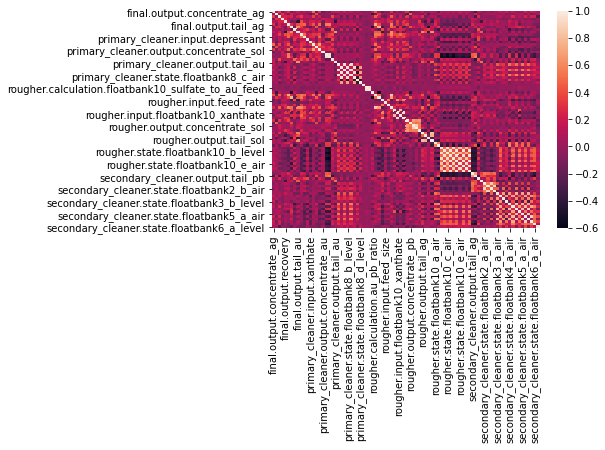

In [3]:
print(f"\n Информация об обучающей выборке \n")
display(train.info())
display(train.describe())
print(train.shape)
print(f"\n Явных дубликатов", train.duplicated().sum())
print(f"\n Тепловая карта корелляции:")
sns.heatmap(train.corr())
display(train.head(7))


 Информация о тестовой выборке 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 no

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


(5290, 53)
Явных дубликатов 0

 Тепловая карта корелляции:


<AxesSubplot:>

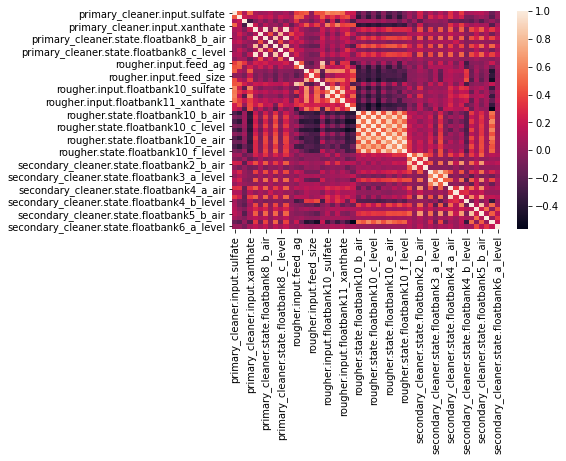

In [4]:
print(f"\n Информация о тестовой выборке \n")
display(test.info())
display(test.describe())
print(test.shape)
print('Явных дубликатов', test.duplicated().sum())
print(f"\n Тепловая карта корелляции:")
sns.heatmap(test.corr())


 Информация о исходных данных 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                      

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


(19439, 87)
Явных дубликатов 0


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470


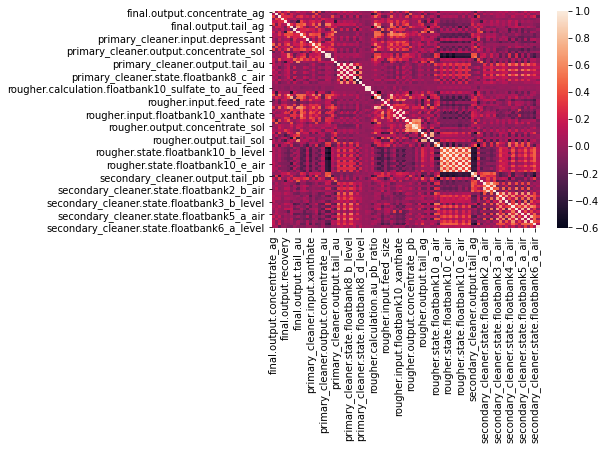

In [5]:
print(f"\n Информация о исходных данных \n")
full.info()
display(full.describe())
print(full.shape)
print('Явных дубликатов', full.duplicated().sum())
sns.heatmap(full.corr())
display(full.head(7))

Выборки различны по объему, имеются пропуски и аномалии, между некоторыми показателями наблюдается сильная корелляция. Пропуски заполню данными из предыдущих значений тк по условиям задачи они близки, аномальные значения удалю.

In [6]:
print(f"Размер обучающей выборки: {train.shape}, размер тестовой выборки: {test.shape}, общей: {full.shape}")

Размер обучающей выборки: (14149, 87), размер тестовой выборки: (5290, 53), общей: (19439, 87)


### Проверю, что эффективность обогащения рассчитана правильно. 

In [7]:
#Рассчет эффективности
recovery = (train['rougher.output.concentrate_au'] * (train ['rougher.input.feed_au'] - train ['rougher.output.tail_au'])) / (train ['rougher.input.feed_au'] * \
                    (train ['rougher.output.concentrate_au'] - train ['rougher.output.tail_au'])) * 100
print(recovery.head())

print(f'\nMAE:', mean_absolute_error(recovery, train['rougher.output.recovery']))

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64

MAE: 9.73512347450521e-15


Значение MAE очень низкое, эффективность обогащения рассчитана правильно.

In [8]:
display(set(train.columns) - set(test.columns))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Данные, которых нет в тестовой - это расчетные данные, которые получаются по результатам замеров, среди них есть целевые столбцы.  В тестовую выборку надо добавить целевые признаки для оценки качества модели в дальнейшем. 

In [9]:
test = test.merge(full[['date', 'final.output.recovery', 'rougher.output.recovery']], how='left', on='date')
display(test.head())

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,68.143213,88.412756
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,67.776393,87.360133
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,61.467078,83.236367


### Предобработка данных.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
В данных были пропуски, заполню их соседними - предыдущими по времени.

In [10]:
train = train.sort_values(by ='date').fillna(method='ffill')
test = test.sort_values(by ='date').fillna(method='ffill')
full = full.sort_values(by ='date').fillna(method='ffill')
# print(train.isna().sum(), test.isna().sum(), full.isna().sum())

## Анализ данных

### Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

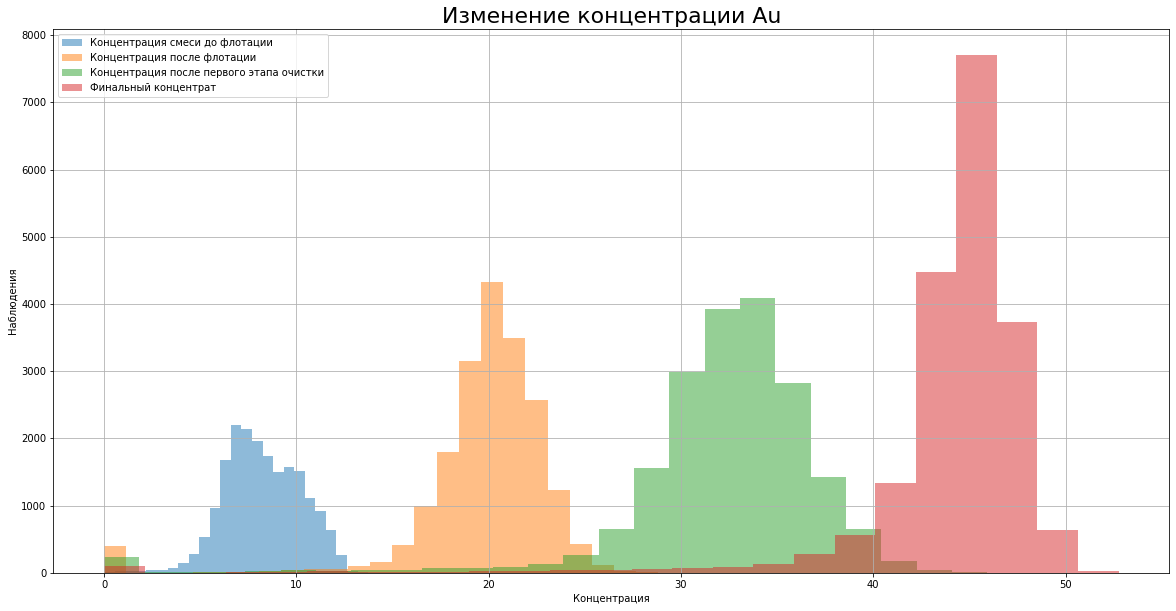

In [11]:
plt.figure(figsize=(20,10))

full['rougher.input.feed_au'].hist(bins=25, label='Концентрация смеси до флотации', alpha=.5)
full['rougher.output.concentrate_au'].hist(bins=25, label='Концентрация после флотации', alpha=.5)
full['primary_cleaner.output.concentrate_au'].hist(bins=25, label='Концентрация после первого этапа очистки', alpha=.5)
full['final.output.concentrate_au'].hist(bins=25, label='Финальный концентрат', alpha=.5)

plt.title('Изменение концентрации Au', fontsize=22)
plt.legend()
plt.xlabel('Концентрация')
plt.ylabel('Наблюдения')

plt.show()

С каждым этапом концентрация золота в сырье увеличивается

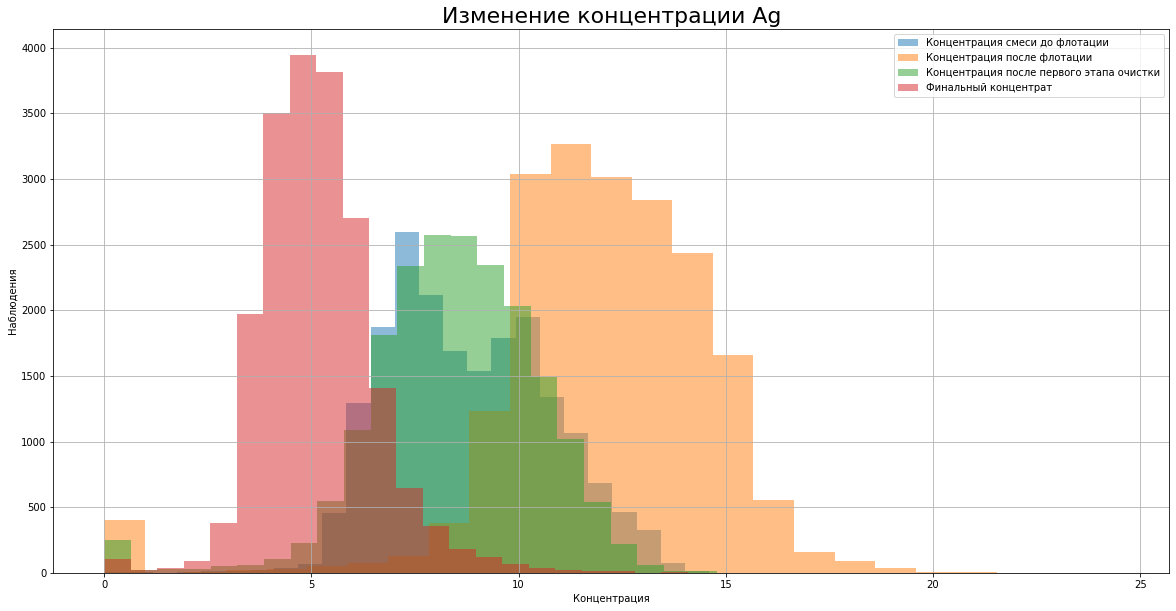

In [12]:
plt.figure(figsize=(20,10))

full['rougher.input.feed_ag'].hist(bins=25, label='Концентрация смеси до флотации', alpha=.5)
full['rougher.output.concentrate_ag'].hist(bins=25, label='Концентрация после флотации', alpha=.5)
full['primary_cleaner.output.concentrate_ag'].hist(bins=25, label='Концентрация после первого этапа очистки', alpha=.5)
full['final.output.concentrate_ag'].hist(bins=25, label='Финальный концентрат', alpha=.5)

plt.title('Изменение концентрации Ag', fontsize=22)
plt.legend()
plt.xlabel('Концентрация')
plt.ylabel('Наблюдения')

plt.show()

Концентрация серебра к финальной стадии уменьшается, после флотации поисходило увеличение концентрации, но в финальном концентрате серебра меньше, чем на первом этапе очистки и до флотации.

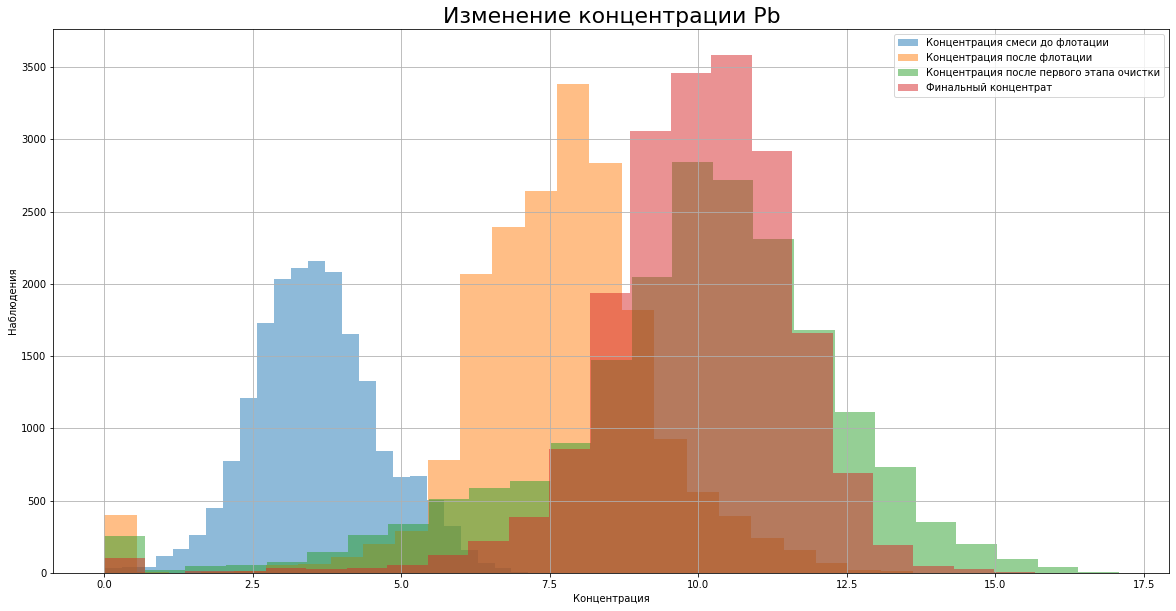

In [13]:
plt.figure(figsize=(20,10))

full['rougher.input.feed_pb'].hist(bins=25, label='Концентрация смеси до флотации', alpha=.5)
full['rougher.output.concentrate_pb'].hist(bins=25, label='Концентрация после флотации', alpha=.5)
full['primary_cleaner.output.concentrate_pb'].hist(bins=25, label='Концентрация после первого этапа очистки', alpha=.5)
full['final.output.concentrate_pb'].hist(bins=25, label='Финальный концентрат', alpha=.5)

plt.title('Изменение концентрации Pb', fontsize=22)
plt.legend()
plt.xlabel('Концентрация')
plt.ylabel('Наблюдения')

plt.show()

Концентрация свинца увеличивается с каждым этапом:значительно после флотации, а после первого этапа очистки в целом не сильно увеличивается по сравнению с финальным концентратом.

Также на всех этапах видно "выбросы" в виде нулевых значении и скошенность признаков, я удалю нулевые значения.

In [14]:
full=full[(full['rougher.input.feed_au']!=0) & (full['rougher.output.concentrate_au']!=0) & \
          (full['primary_cleaner.output.concentrate_au'] != 0) & (full['final.output.concentrate_au']!=0) &\
          (full['rougher.input.feed_ag']!=0) & (full['rougher.output.concentrate_ag']!=0) & \
          (full['primary_cleaner.output.concentrate_ag']!=0) & (full['final.output.concentrate_ag']!=0) &\
          (full['rougher.input.feed_pb']!=0) & (full['rougher.output.concentrate_pb']!=0) & \
          (full['primary_cleaner.output.concentrate_pb']!=0) & (full['final.output.concentrate_pb']!=0) & \
          (full['rougher.input.feed_sol']!=0) & (full['rougher.output.concentrate_sol']!=0) & \
          (full['primary_cleaner.output.concentrate_sol']!=0) & (full['final.output.concentrate_sol']!=0)\
                                                                  ]

In [15]:
train = train[~(train[[i for i in train.columns if i[-2:] in ['au', 'ag', 'pb', 'ol'] and 'tail' not in i]] == 0).any(axis = 1)]
display(train.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### Сравню распределения размеров гранул сырья на обучающей и тестовой выборках. 

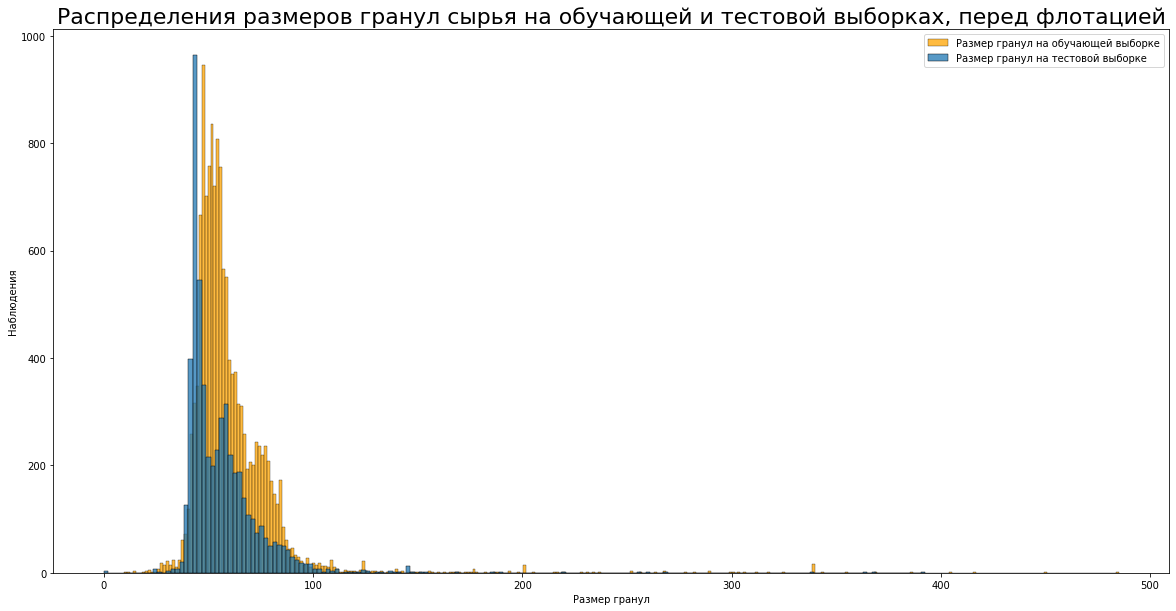

In [16]:
plt.figure (figsize = [20,10])

sns.histplot(train['rougher.input.feed_size'], label='Размер гранул на обучающей выборке', color='orange')
sns.histplot(test['rougher.input.feed_size'], label='Размер гранул на тестовой выборке')
plt.title('Распределения размеров гранул сырья на обучающей и тестовой выборках, перед флотацией', fontsize=22)
plt.legend()
plt.xlabel('Размер гранул')
plt.ylabel('Наблюдения')
plt.show()

In [17]:
print('train перед флотацией')
display(train['rougher.input.feed_size'].describe())
print('test перед флотацией')
display(test['rougher.input.feed_size'].describe())

train перед флотацией


count    13716.000000
mean        60.324221
std         23.122393
min          9.659576
25%         49.020407
50%         55.402093
75%         66.079400
max        484.967466
Name: rougher.input.feed_size, dtype: float64

test перед флотацией


count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

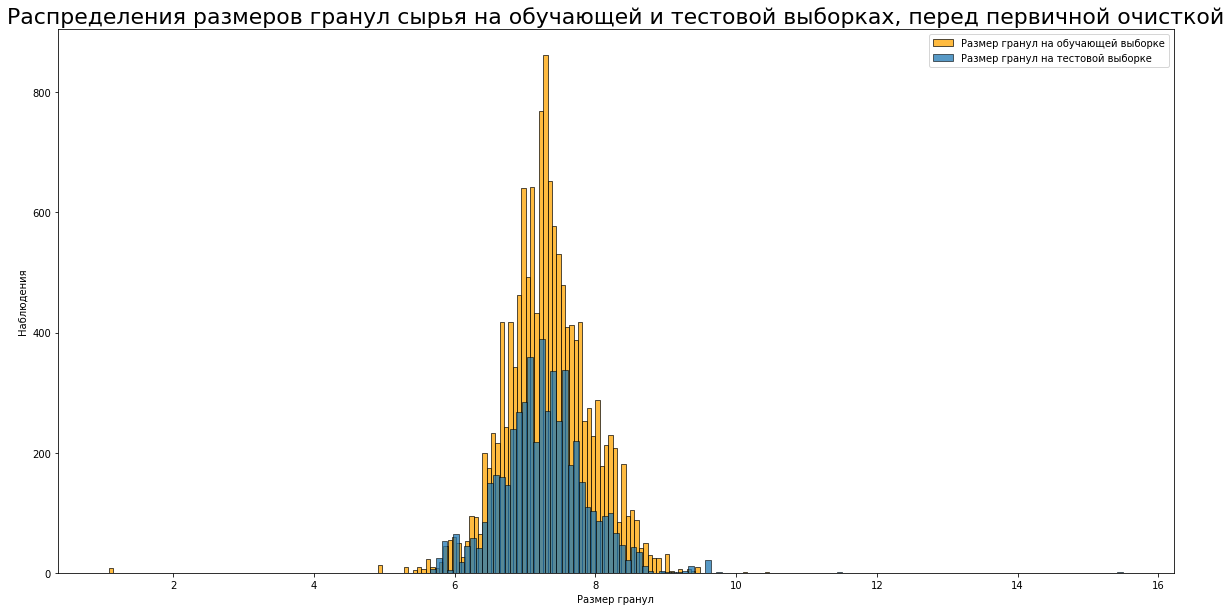

In [18]:
plt.figure (figsize = [20,10])

sns.histplot(train['primary_cleaner.input.feed_size'], label='Размер гранул на обучающей выборке', color='orange')
sns.histplot(test['primary_cleaner.input.feed_size'], label='Размер гранул на тестовой выборке')
plt.title('Распределения размеров гранул сырья на обучающей и тестовой выборках, перед первичной очисткой', fontsize=22)
plt.legend()
plt.xlabel('Размер гранул')
plt.ylabel('Наблюдения')
plt.show()

In [19]:
display(train['primary_cleaner.input.feed_size'].describe())
display(test['primary_cleaner.input.feed_size'].describe())

count    13716.000000
mean         7.324166
std          0.616860
min          1.080000
25%          6.960000
50%          7.300000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

Распределения не сильно отличаются друг от друга, оценка должна быть правильной.

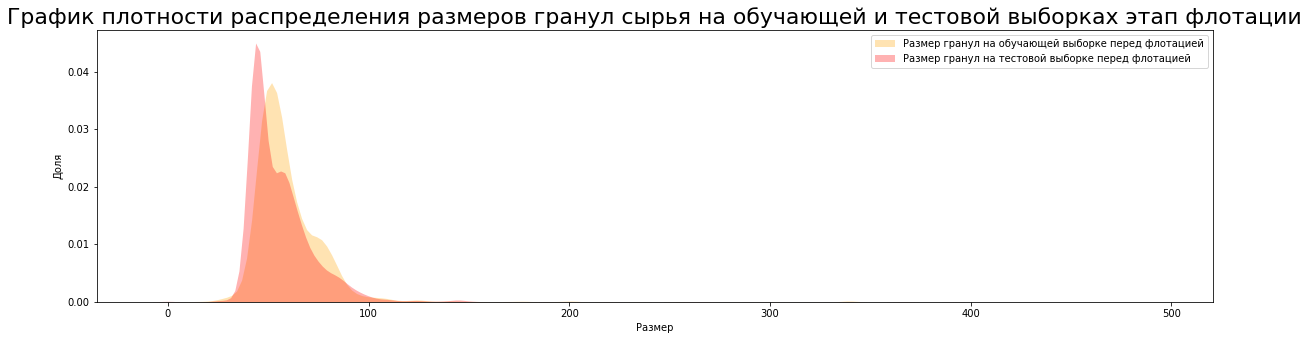

In [20]:
plt.figure (figsize = [20,5])

sns.kdeplot(train['rougher.input.feed_size'], label='Размер гранул на обучающей выборке перед флотацией', color='orange',fill= True , alpha= .3 , linewidth= 0)
sns.kdeplot(test['rougher.input.feed_size'], label='Размер гранул на тестовой выборке перед флотацией',color='red', fill= True , alpha= .3 , linewidth= 0)
plt.title('График плотности распределения размеров гранул сырья на обучающей и тестовой выборках этап флотации', fontsize=22)
plt.legend()
plt.xlabel('Размер')
plt.ylabel('Доля')
plt.show()

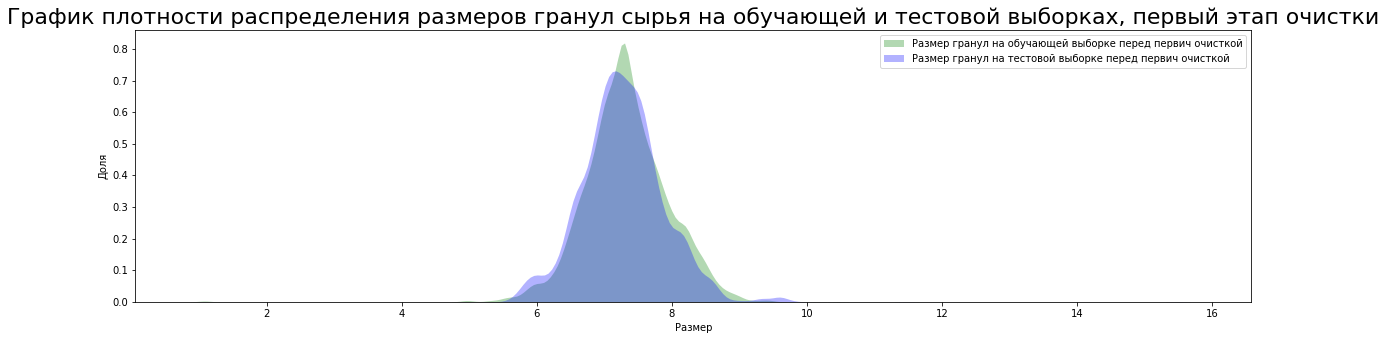

In [21]:
plt.figure (figsize = [20,5])

sns.kdeplot(train['primary_cleaner.input.feed_size'], label='Размер гранул на обучающей выборке перед первич очисткой', color = 'green', fill= True , alpha= .3 , linewidth= 0)
sns.kdeplot(test['primary_cleaner.input.feed_size'], label='Размер гранул на тестовой выборке перед первич очисткой', color = 'blue', fill= True , alpha= .3 , linewidth= 0)

plt.title('График плотности распределения размеров гранул сырья на обучающей и тестовой выборках, первый этап очистки', fontsize=22)
plt.legend()
plt.xlabel('Размер')
plt.ylabel('Доля')
plt.show()

### Исследую суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [22]:
input_feed = full[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis = 1)
rougher_output = full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] 
final_output = full['final.output.concentrate_au'] + full['final.output.concentrate_ag'] + full ['final.output.concentrate_pb']
# print(input_feed.head())
# display(rougher_output.head())

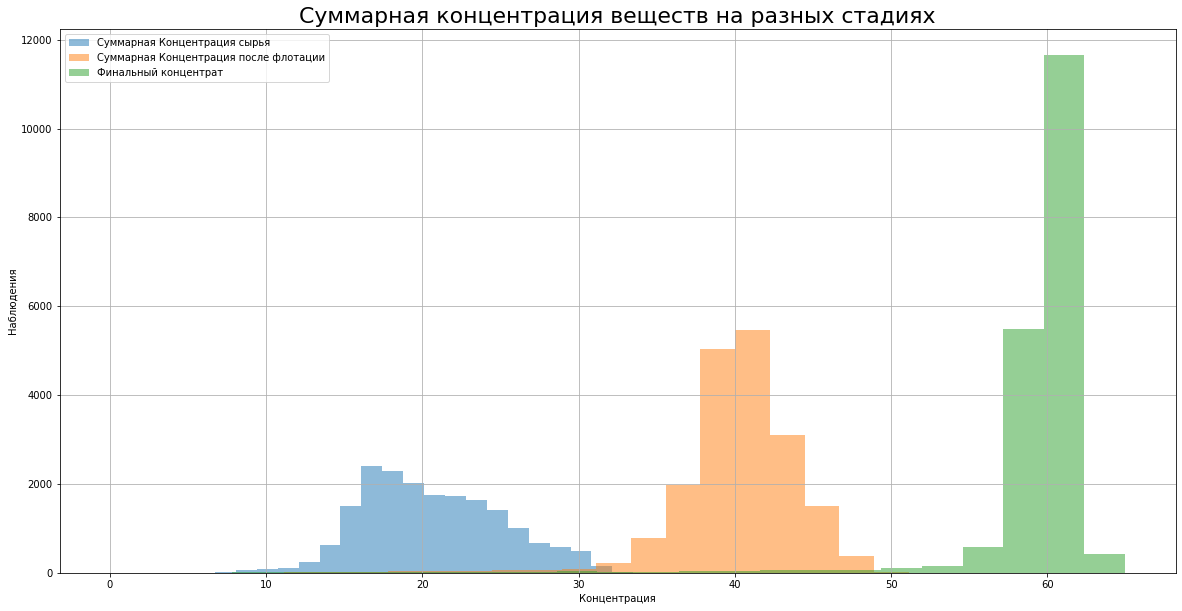

In [23]:
plt.figure(figsize=(20,10))

input_feed.hist(bins=25, label='Суммарная Концентрация сырья', alpha=.5)
rougher_output.hist(bins=25, label='Суммарная Концентрация после флотации', alpha=.5)
final_output.hist(bins=25, label='Финальный концентрат', alpha=.5)

plt.title('Суммарная концентрация веществ на разных стадиях', fontsize=22)
plt.legend()
plt.xlabel('Концентрация')
plt.ylabel('Наблюдения')

plt.show()

Суммарная концентрация веществ увеличивается с каждым этапом.

## Модель

### Функция для вычисления итоговой sMAPE.

![sMAPE](https://pictures.s3.yandex.net/resources/smape_1576238825.jpg) 
![Итоговое sMAPE](https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg)

In [24]:
def smape (target, prediction):
    return (1 / len(target)) * (sum (2 * abs(target - prediction) / (abs (target) + abs (prediction)) * 100))

def final_smape (rougher, final):
    return 0.25 * rougher + 0.75 * final

### Обучаем и ищем лучшую модель


In [25]:
print(f"Размер обучающей выборки: {train.shape}, размер тестовой выборки: {test.shape}, общей: {full.shape}")

Размер обучающей выборки: (13716, 87), размер тестовой выборки: (5290, 55), общей: (18838, 87)


In [26]:
train_drop = set(train.columns) - set(test.columns)
train= train.drop(columns=train_drop, axis=1)
# print(train_drop)

In [27]:
features_train = train.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis = 1)

target_rougher = train['rougher.output.recovery'].reset_index(drop=True)
target_final = train['final.output.recovery'].reset_index(drop=True)
target_df = train[['rougher.output.recovery', 'final.output.recovery']]

print(features_train.shape, target_rougher.shape, target_final.shape, target_df.shape)

(13716, 52) (13716,) (13716,) (13716, 2)


In [28]:

features_targets_columns = list(test.columns)


test_full = full[full['date'].isin(test['date'])]

test_full= test_full[features_targets_columns]

features_test =test_full.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis = 1)
test_df = test_full[['rougher.output.recovery', 'final.output.recovery']]
test_rougher = test_full['rougher.output.recovery']
test_final = test_full['final.output.recovery']
print(features_test.shape,test_rougher.shape,test_final.shape)


(5122, 52) (5122,) (5122,)


Ридж-регрессию лучше применять, когда предсказательная способность набора данных распределена между различными характеристиками. Ридж-регрессия не обнуляет характеристики, которые могут быть полезны при составлении прогнозов, а просто уменьшает вес большинства переменных в модели.

In [31]:
from sklearn.linear_model import Ridge

model_r = Ridge(alpha=0.6)

pipeline = make_pipeline(StandardScaler(), model_r)

smape_scorer = make_scorer(smape, greater_is_better = False)
crossv_rougher = cross_val_score(pipeline, features_train, target_rougher, scoring = smape_scorer, cv=5)
crossv_final = cross_val_score(pipeline, features_train, target_final, scoring = smape_scorer, cv=5)
                                 
print ('Итоговая sMAPE модели Ридж регрессии:', final_smape(crossv_rougher.mean(), crossv_final.mean()))

Итоговая sMAPE модели Ридж регрессии: -10.019252116510147


Лассо-регрессию следует использовать, когда есть несколько характеристик с высокой предсказательной способностью, а остальные бесполезны. Она обнуляет бесполезные характеристики и оставляет только подмножество переменных.

In [32]:
from sklearn import linear_model

model_l = linear_model.Lasso(alpha=0.3)
pipeline = make_pipeline(StandardScaler(), model_l)

smape_scorer = make_scorer(smape, greater_is_better = False)
crossv_rougher = cross_val_score(pipeline, features_train, target_rougher, scoring = smape_scorer, cv=5)
crossv_final = cross_val_score(pipeline, features_train, target_final, scoring = smape_scorer, cv=5)
                                 
print ('Итоговая sMAPE модели Лассо регрессии:', final_smape(crossv_rougher.mean(), crossv_final.mean()))

Итоговая sMAPE модели Лассо регрессии: -8.72693927422355


In [34]:
smape_scorer = make_scorer(smape, greater_is_better = False)

model = Ridge()

pipelin = Pipeline(steps=[("scaler", StandardScaler()), ("model", model)])

parameters = {'model__alpha': [0, 0.7, 0.1]}

search_1= GridSearchCV(pipelin, parameters, scoring=smape_scorer, cv=3)
search_2= GridSearchCV(pipelin, parameters, scoring=smape_scorer, cv=3)

search_rougher = search_1.fit(features_train, target_rougher)

search_final = search_2.fit(features_train, target_final)

# print(pd.Series(search_final.best_score_))
# print(pd.Series(search_final.best_params_))
# print(pd.Series(search_rougher.best_score_))
# print(pd.Series(search_rougher.best_params_))

print ('Итоговая sMAPE модели Ридж регрессии:', final_smape(search_final.best_score_, search_rougher.best_score_)) 

Итоговая sMAPE модели Ридж регрессии: -11.120213951768413


Дерево решений

In [35]:
smape_scorer = make_scorer(smape, greater_is_better = False)

model = DecisionTreeRegressor(random_state = 12345)

pipelin = Pipeline(steps=[("model", model)])

param_grid = {"model__max_depth":range(1,101,10)} # {'model_max_depth':[1, 101, 10]}

search_rougher = GridSearchCV(pipelin, param_grid, scoring = smape_scorer, cv = 5)
search_rougher.fit(features_train, target_rougher)
# print(pd.Series(search_rougher.best_score_))
# print(pd.Series(search_rougher.best_params_))

search_final = GridSearchCV(pipelin, param_grid,scoring = smape_scorer, cv = 5)
search_final.fit(features_train, target_final)
# print(pd.Series(search_final.best_score_))
# print(pd.Series(search_final.best_params_))

print ('Итоговая sMAPE модели Дерево решений:', final_smape(search_rougher.best_score_, search_final.best_score_))

Итоговая sMAPE модели Дерево решений: -9.306249213352302


In [36]:
smape_scorer = make_scorer(smape, greater_is_better = False) #скоринг
model = DecisionTreeRegressor(random_state = 12345) #модель
param_grid = {"max_depth":range(1,101,10)} #vfnhbwf гиперпараметров

search_rougher = GridSearchCV(model, param_grid, scoring = smape_scorer, cv = 5)
search_rougher_cv = search_rougher.fit(features_train, target_rougher)
print(pd.Series(search_rougher_cv.best_score_))
print(pd.Series(search_rougher_cv.best_params_))

search_final = GridSearchCV(model, param_grid,scoring = smape_scorer, cv = 5)
search_final_cv = search_final.fit(features_train, target_final)
print(pd.Series(search_final_cv.best_score_))
print(pd.Series(search_final_cv.best_params_))

print ('Итоговая sMAPE модели Дерево решений:', final_smape(search_rougher_cv.best_score_, search_final_cv.best_score_))


0   -7.999003
dtype: float64
max_depth    1
dtype: int64
0   -9.741998
dtype: float64
max_depth    1
dtype: int64
Итоговая sMAPE модели Дерево решений: -9.306249213352302


Случайный лес

In [37]:
# param_grid = {'max_depth' : range(10,101,10), 'n_estimators' : range(8,18)}
# smape_scorer = make_scorer(smape, greater_is_better = False)

best_smape = -100
best_est = 0
best_depth = 0
for est in range (1, 5):
    for depth in range (1, 5):
        model = RandomForestRegressor (random_state = 12345, n_estimators = est, max_depth = depth)
        smape_scorer = make_scorer(smape, greater_is_better = False)
        crossv_rougher = cross_val_score (model, features_train, target_rougher, scoring = smape_scorer, cv=5)
        crossv_final = cross_val_score (model, features_train, target_final, scoring = smape_scorer, cv=5)
        bsmape = final_smape(crossv_rougher.mean(), crossv_final.mean())
        if abs (bsmape) < abs (best_smape):
            best_smape = bsmape
            best_est = est
            best_depth = depth
print ("Итоговая sMAPE лучшей модели:", best_smape, "Количество деревьев:", best_est, "Глубина:", best_depth)


Итоговая sMAPE лучшей модели: -8.410884557147837 Количество деревьев: 4 Глубина: 4


Лучшее качество показала модель случайный лес с гиперпараметрами: кол-во деревьев 4, глубина 4.

In [38]:
model = RandomForestRegressor (random_state = 12345, n_estimators = 4, max_depth = 4)

model.fit(features_train, target_rougher)
pred_rougher = model.predict(features_test)
rougher = smape(test_rougher, pred_rougher)

model.fit(features_train, target_final)
pred_final = model.predict(features_test)
final = smape(test_final, pred_final)

print ('Итоговая sMAPE модели Случайный лес на тестовой выборке: {}'.format(round(final_smape(rougher, final),2)))

Итоговая sMAPE модели Случайный лес на тестовой выборке: 7.69


Проверим, нет ли каких-то более простых алгоритмов, которые работают лучше чем наш, более сложный через  DummyRegressor

In [39]:
from sklearn.dummy import DummyRegressor

dc_rougher = DummyRegressor(strategy='mean')
dc_final = DummyRegressor(strategy='mean')

dc_rougher.fit(features_train, target_rougher)
predictions_rougher = model.predict(features_test)

dc_final.fit (features_train, target_final)
predictions_final = model.predict (features_test)

smape = final_smape (smape(test_rougher, predictions_rougher), 
                     smape(test_final, predictions_final))

print ('Итоговая sMAPE  константной модели на тестовых данных равна: {}'.format(round(smape,2)))

Итоговая sMAPE  константной модели на тестовых данных равна: 12.82


Итоговый вывод:

Передо мной стояла задача подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды, что поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В ходе работы была проанализирована концентрация металлов на каждом из этапов очистки руды, исследовано изменение размера гранул сырья, была создана формула для расчета smape (симметричный средний процент отклонения), обучена модель. Точность обученной модели была проверена с помощью smape, качество модели проверено на тестовой выборке, smape более простой модели хуже ,чем  Итоговая sMAPE модели Случайный лес на тестовой выборке точнее (составляет 7.688303011763811 против 67.25), значит, прототип модели качественный.